Current working directory: /root/capsule/code/Figure2/Figure2b/Figure2b
6 Proteins AUC: 0.724 (95% CI: 0.711 – 0.738, p-value vs 0.5: 0.0000e+00)
APOE AUC: 0.649 (95% CI: 0.636 – 0.664, p-value vs 0.5: 0.0000e+00)
Age + Sex + BMI AUC: 0.805 (95% CI: 0.795 – 0.816, p-value vs 0.5: 0.0000e+00)
6 Proteins + Age + Sex + BMI AUC: 0.815 (95% CI: 0.804 – 0.825, p-value vs 0.5: 0.0000e+00)

Pairwise DeLong Tests:
6 Proteins vs. APOE: z=17.745, p-value=1.8949e-70 (AUC1=0.724, AUC2=0.649, var1=0.000048, var2=0.000050, cov=0.000040, var_sum=0.000017)
6 Proteins vs. Age + Sex + BMI: z=-47.817, p-value=0.0000e+00 (AUC1=0.724, AUC2=0.805, var1=0.000048, var2=0.000031, cov=0.000038, var_sum=0.000003)
6 Proteins vs. 6 Proteins + Age + Sex + BMI: z=-48.602, p-value=0.0000e+00 (AUC1=0.724, AUC2=0.815, var1=0.000048, var2=0.000029, cov=0.000037, var_sum=0.000004)
APOE vs. Age + Sex + BMI: z=-33.847, p-value=4.0361e-251 (AUC1=0.649, AUC2=0.805, var1=0.000050, var2=0.000031, cov=0.000030, var_sum=0.000021)

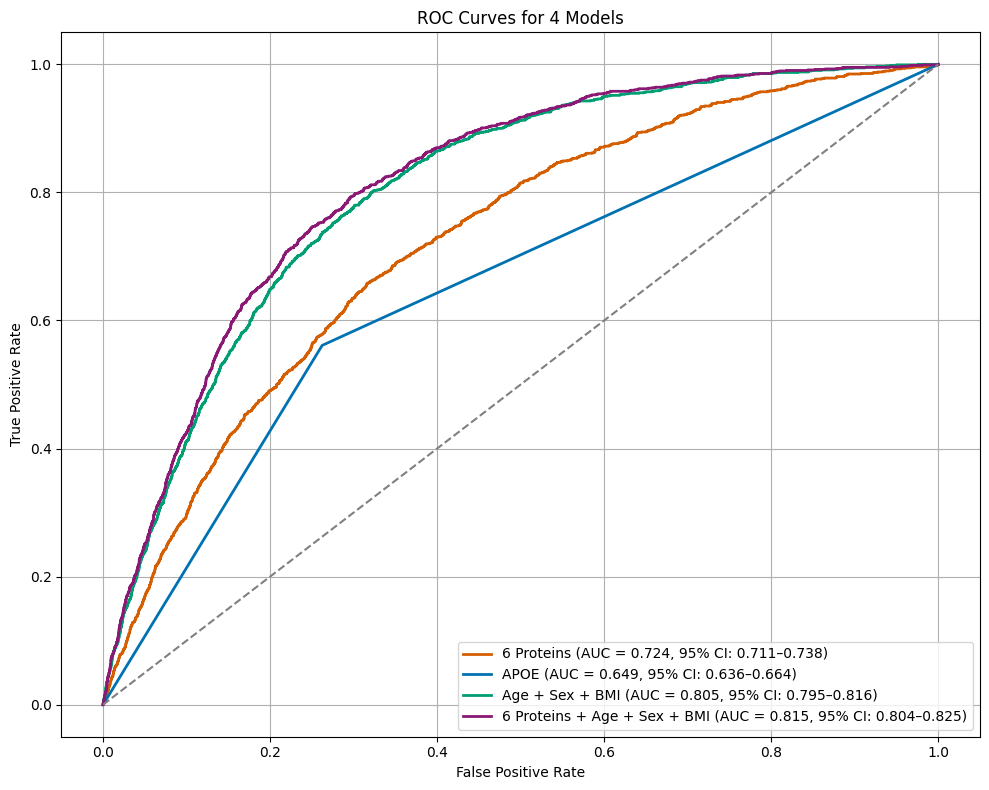

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import os
from scipy.stats import norm

# Get the current working directory and set it as the working path
notebook_path = os.getcwd()
os.chdir(notebook_path)
print("Current working directory:", os.getcwd())

# === Custom function: Bootstrap AUC confidence interval and p-value ===
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=1000, ci=0.95, random_state=42):
    np.random.seed(random_state)
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        indices = resample(np.arange(len(y_true)), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_scores[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    lower_bound = np.percentile(sorted_scores, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(sorted_scores, (1 + ci) / 2 * 100)
    p_value = np.mean(np.array(bootstrapped_scores) <= 0.5)
    return lower_bound, upper_bound, p_value

# === DeLong test implementation ===
def delong_roc_variance(y_true, y_scores):
    """
    Compute ROC AUC variance and components for DeLong test
    """
    n = len(y_true)
    n_pos = np.sum(y_true == 1)
    n_neg = n - n_pos
    if n_pos < 2 or n_neg < 2:
        raise ValueError(f"Insufficient samples: n_pos={n_pos}, n_neg={n_neg}")
    # Sort predictions and true labels
    order = np.argsort(-y_scores)
    y_true = y_true[order]
    y_scores = y_scores[order]
    # Compute V10 and V01
    V10 = np.array([(np.sum(y_scores[y_true == 0] < p) + 0.5 * np.sum(y_scores[y_true == 0] == p)) / n_neg for p in y_scores[y_true == 1]])
    V01 = np.array([(np.sum(y_scores[y_true == 1] > n) + 0.5 * np.sum(y_scores[y_true == 1] == n)) / n_pos for n in y_scores[y_true == 0]])
    auc = np.mean(V10) if len(V10) > 0 else 0.5
    S10 = np.var(V10, ddof=1) if len(V10) > 1 else 0
    S01 = np.var(V01, ddof=1) if len(V01) > 1 else 0
    var = S10 / n_pos + S01 / n_neg if n_pos > 0 and n_neg > 0 else 1e-10
    return auc, var, V10, V01

def delong_roc_test(y_true, y_scores1, y_scores2):
    """
    Perform DeLong test to compare two ROC AUCs
    """
    auc1, var1, V10_1, V01_1 = delong_roc_variance(y_true, y_scores1)
    auc2, var2, V10_2, V01_2 = delong_roc_variance(y_true, y_scores2)
    n_pos = np.sum(y_true == 1)
    n_neg = np.sum(y_true == 0)
    cov = 0
    if len(V10_1) > 1 and len(V10_2) > 1:
        cov += np.cov(V10_1, V10_2, ddof=1)[0, 1] / n_pos
    if len(V01_1) > 1 and len(V01_2) > 1:
        cov += np.cov(V01_1, V01_2, ddof=1)[0, 1] / n_neg
    var_sum = var1 + var2 - 2 * cov
    if var_sum <= 0:
        var_sum = 1e-10
    z = (auc1 - auc2) / np.sqrt(var_sum)
    p_value = 2 * norm.cdf(-np.abs(z))
    return z, p_value, auc1, auc2, var1, var2, cov, var_sum

# === 1. Load data ===
data = pd.read_csv("/code/Figure2/Figure2b/Figure2b/roc_data.csv")

# === 2. Define model features ===
models = {
    "6 Proteins": ['APOM', 'CD276', 'EGFR', 'GDF15', 'GHRL', 'LGALS4'],
    "APOE": ['APOEe4_carrier'],
    "Age + Sex + BMI": ['age', 'sex', 'BMI'],
    "6 Proteins + Age + Sex + BMI": ['APOM', 'CD276', 'EGFR', 'GDF15', 'GHRL', 'LGALS4', 'age', 'sex', 'BMI']
}

colors = ['#D55E00', '#0072B2', '#009E73', '#8a1874']
line_width = 2
plt.figure(figsize=(10, 8))

# Store AUC, CI, p-value, and probs
auc_values = {}
probs_dict = {}

# === 3. Loop through models ===
for i, (model_name, features) in enumerate(models.items()):
    model_data = data[features + ['Dementia_type']].dropna()
    X = model_data[features]
    y = model_data['Dementia_type']
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    probs = model.predict_proba(X)[:, 1]
    probs_dict[model_name] = probs
    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)
    # Compute 95% CI and p-value using bootstrapping
    ci_low, ci_high, p_val_single = bootstrap_auc_ci(y.values, probs)
    auc_values[model_name] = (roc_auc, ci_low, ci_high, p_val_single)
    # Print result
    print(f"{model_name} AUC: {roc_auc:.3f} (95% CI: {ci_low:.3f} – {ci_high:.3f}, p-value vs 0.5: {p_val_single:.4e})")
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], lw=line_width,
             label=f"{model_name} (AUC = {roc_auc:.3f}, 95% CI: {ci_low:.3f}–{ci_high:.3f})")

# === 4. Pairwise DeLong comparisons ===
print("\nPairwise DeLong Tests:")
model_names = list(models.keys())
for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        try:
            z, p_val, auc1, auc2, var1, var2, cov, var_sum = delong_roc_test(y.values, probs_dict[model_names[i]], probs_dict[model_names[j]])
            # Use scientific notation for p-value with higher precision
            print(f"{model_names[i]} vs. {model_names[j]}: z={z:.3f}, p-value={p_val:.4e} (AUC1={auc1:.3f}, AUC2={auc2:.3f}, var1={var1:.6f}, var2={var2:.6f}, cov={cov:.6f}, var_sum={var_sum:.6f})")
        except Exception as e:
            print(f"Error in {model_names[i]} vs. {model_names[j]}: {str(e)}")

# === 5. Plot settings ===
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curves for 4 Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# === 6. Save as PDF ===
plt.savefig("/results/roc_all_with_ci.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import os

# Set the current working directory to the notebook's location
notebook_path = os.getcwd()
os.chdir(notebook_path)
print("Current working directory:", os.getcwd())

# Function to calculate bootstrap confidence interval for AUC
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=1000, ci=0.95, random_state=42):
    np.random.seed(random_state)
    bootstrapped_scores = []
    for _ in range(n_bootstraps):
        indices = resample(np.arange(len(y_true)), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue  # Skip if only one class in resample
        score = roc_auc_score(y_true[indices], y_scores[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.sort(bootstrapped_scores)
    lower = np.percentile(sorted_scores, (1 - ci) / 2 * 100)
    upper = np.percentile(sorted_scores, (1 + ci) / 2 * 100)
    return lower, upper

# Load and filter data for APOE e4 carriers only
data = pd.read_csv("/code/Figure2/Figure2b/Figure2b/roc_data.csv")
data = data[data["APOEe4_carrier"] == 1]

# Define models with their corresponding features
models = {
    "6 Proteins": ['APOM', 'CD276', 'EGFR', 'GDF15', 'GHRL', 'LGALS4'],
    "Age + Sex + BMI": ['age', 'sex', 'BMI'],
    "6 Proteins + Age + Sex + BMI": ['APOM', 'CD276', 'EGFR', 'GDF15', 'GHRL', 'LGALS4', 'age', 'sex', 'BMI']
}

# Set color palette for ROC curves
colors = ['#D55E00', '#009E73', '#8a1874']
plt.figure(figsize=(10, 8))

# Loop through each model, fit and evaluate
for i, (model_name, features) in enumerate(models.items()):
    model_data = data[features + ['Dementia_type']].dropna()
    X = model_data[features]
    y = model_data['Dementia_type']

    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    probs = model.predict_proba(X)[:, 1]

    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)
    ci_low, ci_high = bootstrap_auc_ci(y.values, probs)

    # Print AUC with 95% CI
    print(f"{model_name} AUC: {roc_auc:.3f} (95% CI: {ci_low:.3f} – {ci_high:.3f})")

    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f"{model_name} (AUC = {roc_auc:.3f}, 95% CI: {ci_low:.3f}–{ci_high:.3f})")

# Plot diagonal line (random classifier reference)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curves (APOE e4 Carriers)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# Save figure as PDF
plt.savefig("/results/roc_e4_carrier_with_ci.pdf", format='pdf', bbox_inches='tight')
plt.show()



Current working directory: /root/capsule/code/Figure2/Figure2b/Figure2b
6 Proteins AUC: 0.736 (95% CI: 0.716 – 0.754)
Age + Sex + BMI AUC: 0.843 (95% CI: 0.829 – 0.856)


Current working directory: /root/capsule/code/Figure2/Figure2b/Figure2b
6 Proteins AUC: 0.721 (95% CI: 0.700 – 0.741)
Age + Sex + BMI AUC: 0.767 (95% CI: 0.749 – 0.786)
6 Proteins + Age + Sex + BMI AUC: 0.783 (95% CI: 0.765 – 0.801)


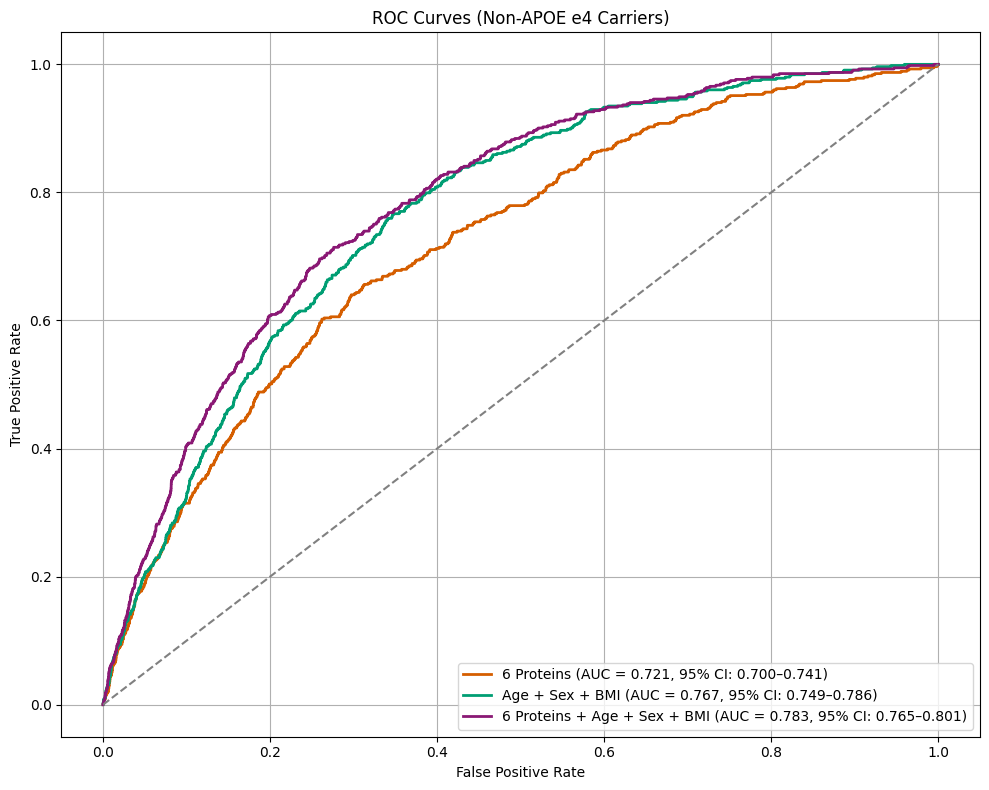

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import os

# Set the current working directory to the notebook's location
notebook_path = os.getcwd()
os.chdir(notebook_path)
print("Current working directory:", os.getcwd())

# Function to calculate bootstrap confidence interval for AUC
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=1000, ci=0.95, random_state=42):
    np.random.seed(random_state)
    bootstrapped_scores = []
    for _ in range(n_bootstraps):
        indices = resample(np.arange(len(y_true)), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue  # Skip resamples with only one class
        score = roc_auc_score(y_true[indices], y_scores[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.sort(bootstrapped_scores)
    lower = np.percentile(sorted_scores, (1 - ci) / 2 * 100)
    upper = np.percentile(sorted_scores, (1 + ci) / 2 * 100)
    return lower, upper

# Load and filter data for non-APOE e4 carriers only
data = pd.read_csv("/code/Figure2/Figure2b/Figure2b/roc_data.csv")
data = data[data["APOEe4_carrier"] == 0]

# Define models with corresponding features
models = {
    "6 Proteins": ['APOM', 'CD276', 'EGFR', 'GDF15', 'GHRL', 'LGALS4'],
    "Age + Sex + BMI": ['age', 'sex', 'BMI'],
    "6 Proteins + Age + Sex + BMI": ['APOM', 'CD276', 'EGFR', 'GDF15', 'GHRL', 'LGALS4', 'age', 'sex', 'BMI']
}

# Set color palette for ROC curves
colors = ['#D55E00', '#009E73', '#8a1874']
plt.figure(figsize=(10, 8))

# Loop through each model, fit and evaluate
for i, (model_name, features) in enumerate(models.items()):
    model_data = data[features + ['Dementia_type']].dropna()
    X = model_data[features]
    y = model_data['Dementia_type']

    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    probs = model.predict_proba(X)[:, 1]

    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)
    ci_low, ci_high = bootstrap_auc_ci(y.values, probs)

    # Print AUC with 95% CI
    print(f"{model_name} AUC: {roc_auc:.3f} (95% CI: {ci_low:.3f} – {ci_high:.3f})")

    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f"{model_name} (AUC = {roc_auc:.3f}, 95% CI: {ci_low:.3f}–{ci_high:.3f})")

# Plot reference diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curves (Non-APOE e4 Carriers)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# Save the plot as a PDF
plt.savefig("/results/roc_non_e4_carrier_with_ci.pdf", format='pdf', bbox_inches='tight')
plt.show()

